<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/patient_image.png" width="30%" align="right"/>

# Building a Binary Classification Machine Learning Model To Predict Hospital Readmission in Patients with Diabetes

In this tutorial, we'll be looking at hospital admission data in patients with diabetes. This dataset was collected from 130 hospitals in the United States from 1999 to 2008. More details can be found on the UCI Machine Learning Repository [website](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).

## Step 1: Importing Depedencies

Before getting started, we'll need to import several packages. These include:

- [pandas](https://pandas.pydata.org/pandas-docs/stable/) - a package for performing data analysis and manipulation
- [numpy](https://docs.scipy.org/doc/numpy/) - a package for scientific computing 
- [matplotlib](https://matplotlib.org/) - the standard Python plotting package
- [seaborn](https://seaborn.pydata.org/) - a dataframe-centric visualization package that is built off of **matplotlib**

In [100]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load the Data

We will be loading in the data as a pandas DataFrame.

The data is stored in a csv file. We'll import this data using a pandas method called `read_csv`.

In [102]:
data = pd.read_csv("../data/patient_data.csv")

To get a glimpse of our data, we can use either the `head()`, which shows the first 5 rows of the dataframe.

In [16]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,admission_source_id,time_in_hospital,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,1,1,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,7,3,NaN,...,No,No,Up,No,No,No,No,No,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,7,2,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,7,2,NaN,...,No,No,Up,No,No,No,No,No,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,7,1,NaN,...,No,No,Steady,No,No,No,No,No,Yes,NO


### How many rows and columns are in our dataset?

In [17]:
data.shape

(101766, 44)

Our dataset has 101,766 rows and 45 columns. Each row represents a unique hospital admission. Columns represent patient demographics, medical details, and admission-specific information such as length of stay (`time_in_hospital`). We can see a list of all columns by applying `.columns` to our dataframe.

In [18]:
print(f"Columns: {data.columns.tolist()}")

Columns: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetesMed', 'readmitted']


Looking at the columns, we can see that a large proportion are medication names. Let's store these column names as a separate list, which we'll get back to in a bit.

In [19]:
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

print(f"There are {len(medications)} medications represented as columns in the dataset.")

There are 23 medications represented as columns in the dataset.


### How many hospital admissions and unique patients are in the dataset? 

In [20]:
n_admissions = data['encounter_id'].nunique()
n_patients = data['patient_nbr'].nunique()

print(f"Number of hospital admissions: {n_admissions:,}")
print(f"Number of unique patients: {n_patients:,}")

Number of hospital admissions: 101,766
Number of unique patients: 71,518


### How many patients have had more than one hospital admission?

In [21]:
admissions_per_patient = data['patient_nbr'].value_counts().reset_index()
admissions_per_patient.columns = ['patient_nbr', 'count']
multiple_admissions = admissions_per_patient[admissions_per_patient['count'] > 1]

In [22]:
print(f"Proportion of patients that have multiple admissions: {multiple_admissions['patient_nbr'].nunique()/n_patients:.2%}")
print(f"Maximum number of admissions for a given patient: {multiple_admissions['count'].max()}")

Proportion of patients that have multiple admissions: 23.45%
Maximum number of admissions for a given patient: 40


Almost one-quarter of the patients (23.45%) have had more than 1 hosptial admission. The maximum number of hospital admissions for a given patient is 40. 

## Step 3: Data Cleaning

Data cleaning is a crucial step in the machine learning pipeline, and typically requires the most time and effort.

### i) Decoding admission_type_id

The `admission_type_id` column represent ID's that link to descriptors in separate files: 

1. `admission_type_id`
2. `admission_source_id`

In the original dataset, these columns are represented as integers. 

In [23]:
data[['admission_type_id', 'admission_source_id']].head()

,admission_type_id,admission_source_id
0,6,1
1,1,7
2,1,7
3,1,7
4,1,7


We'll update these columns so that they represent the descriptor name instead of simply the id number.

Our mapper files are located in `data/id_mappers/` as shown below.

In [24]:
import glob

glob.glob('../data/id_mappers/*.csv')

['../data/id_mappers/admission_source_id.csv',
 '../data/id_mappers/admission_type_id.csv']

#### Decoding  `admission_type_id`

In [25]:
admission_type = pd.read_csv("../data/id_mappers/admission_type_id.csv")
admission_type

,admission_type_id,description
0,1,Emergency
1,2,Urgent
...,...,...
6,7,Trauma Center
7,8,Not Mapped


We can see that the admission type mapper file has 3 values which represent missing data:

1. NaN
2. 'Not Mapped'
3. 'Not Available'

Let's collapse these into one category that represents a missing value. 

In [26]:
missing_values = ['nan', 'Not Available', 'Not Mapped']
admission_type['description'] = admission_type['description'].replace(missing_values, np.nan)

In [27]:
admission_type_mapper = admission_type.to_dict()['description']
admission_type_mapper

{0: 'Emergency',
 1: 'Urgent',
 2: 'Elective',
 3: 'Newborn',
 4: nan,
 5: nan,
 6: 'Trauma Center',
 7: nan}

Now that we have a "clean" mapper, we can apply it to our dataset. We can use [pandas.Series.map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html) to map `admission_type_id` values in our original dataframe to the descriptors in our `admission_type_mapper` dictionary.

In [28]:
data['admission_type'] = data['admission_type_id'].map(admission_type_mapper)
data[['admission_type']].head()

,admission_type
0,Trauma Center
1,Urgent
2,Urgent
3,Urgent
4,Urgent


#### Decoding  `admission_source_id`

In [29]:
admission_source = pd.read_csv("../data/id_mappers/admission_source_id.csv")
admission_source.shape

(25, 2)

There are significantly more ID's represented in the `admission_source_id.csv` file as compared to `admission_type_id.csv`. Let's take a look at the list of all descriptions.

In [30]:
admission_source['description'].tolist()

['Physician Referral',
 'Clinic Referral',
 'HMO Referral',
 'Transfer from a hospital',
 'Transfer from a Skilled Nursing Facility (SNF)',
 'Transfer from another health care facility',
 'Emergency Room',
 'Court/Law Enforcement',
 'Not Available',
 'Transfer from critial access hospital',
 'Normal Delivery',
 'Premature Delivery',
 'Sick Baby',
 'Extramural Birth',
 'Not Available',
 nan,
 'Transfer From Another Home Health Agency',
 'Readmission to Same Home Health Agency',
 'Not Mapped',
 'Unknown/Invalid',
 'Transfer from hospital inpt/same fac reslt in a sep claim',
 'Born inside this hospital',
 'Born outside this hospital',
 'Transfer from Ambulatory Surgery Center',
 'Transfer from Hospice']

Here, we can see that there are 4 missing values:

- 'Not Available' 
- 'Unknown/Invalid'
- 'Not Mapped'
- 'nan'

In [31]:
missing_values = ['nan', 'Not Available', 'Not Mapped', 'Unknown/Invalid']
admission_source['description'] = admission_source['description'].replace(missing_values, np.nan)

There are also a couple of overlapping themes in admission source descriptions. For example, `'Physician Referral'`, `'Clinic Referral'`, and `'HMO Referral'` can be grouped as `Referral`. Let's do this now using pandas' replace() method.

In [32]:
referrals = ['Physician Referral', 'Clinic Referral', 'HMO Referral']
admission_source['description'] = admission_source['description'].replace(referrals, 'Referral')

We can also group transfer-related admission sources into a single description called `Transfer`. There are 8 admission sources that include `'Transfer'`. Instead of going through the list and selecting these manually, we're going to use pandas.Series's [contains()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html) method to filter out admission source descriptions that contain the string `'Transfer'`. 

In [33]:
transfers = admission_source[admission_source['description'].str.contains('Transfer').fillna(False)]
transfers

,admission_source_id,description
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)
...,...,...
23,25,Transfer from Ambulatory Surgery Center
24,26,Transfer from Hospice


Let's generate a list of all transfer-related admission source descriptions.

In [34]:
transfers = transfers['description'].tolist()
transfers

['Transfer from a hospital',
 'Transfer from a Skilled Nursing Facility (SNF)',
 'Transfer from another health care facility',
 'Transfer from critial access hospital',
 'Transfer From Another Home Health Agency',
 'Transfer from hospital inpt/same fac reslt in a sep claim',
 'Transfer from Ambulatory Surgery Center',
 'Transfer from Hospice']

In [35]:
admission_source['description'] = admission_source['description'].replace(transfers, 'Transfer')

Let's now convert this into a dictionary.

In [36]:
admission_source_mapper = admission_source.to_dict()['description']
admission_source_mapper

{0: 'Referral',
 1: 'Referral',
 2: 'Referral',
 3: 'Transfer',
 4: 'Transfer',
 5: 'Transfer',
 6: 'Emergency Room',
 7: 'Court/Law Enforcement',
 8: nan,
 9: 'Transfer',
 10: 'Normal Delivery',
 11: 'Premature Delivery',
 12: 'Sick Baby',
 13: 'Extramural Birth',
 14: nan,
 15: nan,
 16: 'Transfer',
 17: 'Readmission to Same Home Health Agency',
 18: nan,
 19: nan,
 20: 'Transfer',
 21: 'Born inside this hospital',
 22: 'Born outside this hospital',
 23: 'Transfer',
 24: 'Transfer'}

Now we can apply this mapper to the `admission_source_id` column in our original dataset.

In [37]:
data['admission_source'] = data['admission_source_id'].map(admission_source_mapper)
data[['admission_source']].head()

,admission_source
0,Referral
1,Court/Law Enforcement
2,Court/Law Enforcement
3,Court/Law Enforcement
4,Court/Law Enforcement


### Converting Medication Features From Categorical to Boolean

Remember that list of medications we created when we loaded in the data in Step 1? We're going to take these medication columns in our dataset and convert these features to boolean variables. 

In [38]:
data[medications[0]].value_counts()

No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64

Medication columns are currently categorical datatypes that have several possible categories including:

- "No" (not taking the medication)
- "Up" (increased medication dose)
- "Down" (decrease medication dose)
- "Steady" (no changes in dose)

To keep things simple, we'll update the column to "0" (not taking the medication) to "1" (taking the medication). We're losing out on information regarding their dose change, but it's a compromise we're willing to make to simplify our dataset.

We can use [numpy.where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) to 

In [39]:
for m in medications:
    data[f'{m}_bool'] = np.where(data[m]=='No', 0, 1)

Let's take a look at the prevelance of these medications. We'll calcualte the proportion of patients taking each type of medication. Because some patients have had multiple hospital admissions in this dataset, we'll need to do some wrangling to determine whether a patient was on a given medication during any of their admissions. We'll apply `groupby` to `patient_nbr` and calculate the sum of admissions in which the patient was administered a medication. 

In [63]:
prevelance = []

for m in medications:
    patient_meds = data.groupby('patient_nbr')[f'{m}_bool'].sum().reset_index()
    patient_meds[f'{m}_bool'] = patient_meds[f'{m}_bool'].astype(bool)
    n_patients_on_med = patient_meds[f'{m}_bool'].sum()
    proportion = n_patients_on_med/n_patients
    prevelance.append(proportion)

Now that we have a list of medication prevelance, we can create a dataframe and sort by prevelance to determine which medications are most prevelant in our dataset. 

In [73]:
medication_counts = pd.DataFrame({'medication': medications, 'prevelance':prevelance})

medication_counts = medication_counts.sort_values(by='prevelance', ascending=False)
medication_counts.head()

,medication,prevelance
17,insulin,0.553385
0,metformin,0.230390
6,glipizide,0.139797
7,glyburide,0.119662
9,pioglitazone,0.083042


Let's also visualize the top 10 most prevelance medications. We'll use `seaborn`'s [barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) method.

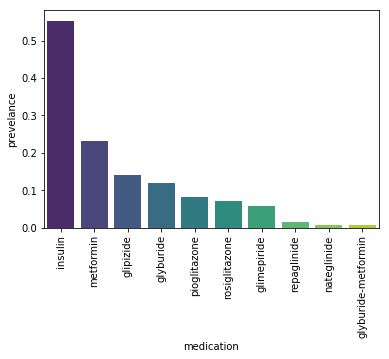

In [85]:
sns.barplot(x='medication', y='prevelance', data=medication_counts.head(10), palette='viridis')
plt.xticks(rotation=90)
plt.show()

In [108]:
from utils import get_mesh_from_drug_name

top_ten_meds = medication_counts.head(10)['medication'].tolist()

med_mesh_descriptors = dict()
for m in top_ten_meds:
    med_mesh_descriptors[m] = get_mesh_from_drug_name(m)

In [110]:
med_mesh_descriptors

{'insulin': [],
 'metformin': ['Hypoglycemic Agents'],
 'glipizide': ['Hypoglycemic Agents'],
 'glyburide': ['Hypoglycemic Agents'],
 'pioglitazone': ['Hypoglycemic Agents'],
 'rosiglitazone': ['Hypoglycemic Agents'],
 'glimepiride': ['Anti-Arrhythmia Agents',
  'Immunosuppressive Agents',
  'Hypoglycemic Agents'],
 'repaglinide': ['Hypoglycemic Agents'],
 'nateglinide': ['Hypoglycemic Agents'],
 'glyburide-metformin': ['Hypoglycemic Agents']}

MeSH terms are a type of "tag" that describes a medical term. We used RxNav's API to further investigate which MeSH terms are assocaited with our list of medications. The results show that all medications have a single MeSH term, [hypoglycemic agent](https://en.wikipedia.org/wiki/Anti-diabetic_medication), which means it's an anti-diabetic medication.

If you want to learn more about each medication in our dataset, check out the [RxNav dashboard](https://mor.nlm.nih.gov/RxNav/) which gives an overview of medication properties and interactions.

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/rxnav_dashboard.png" width="70%"/>

### Creating a Target Variable

In [37]:
data['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [38]:
data['readmitted_bool'] = np.where(data['readmitted']=='NO', 0, 1)

In [39]:
data['readmitted_bool'].value_counts()

0    54864
1    46902
Name: readmitted_bool, dtype: int64

## Step 4: Data Exploration and Visualization

### Assessing Missing Values

To get a better sense of the missing values in our data, let's visualize it using [missingno](https://github.com/ResidentMario/missingno)'s "nullity" matrix.

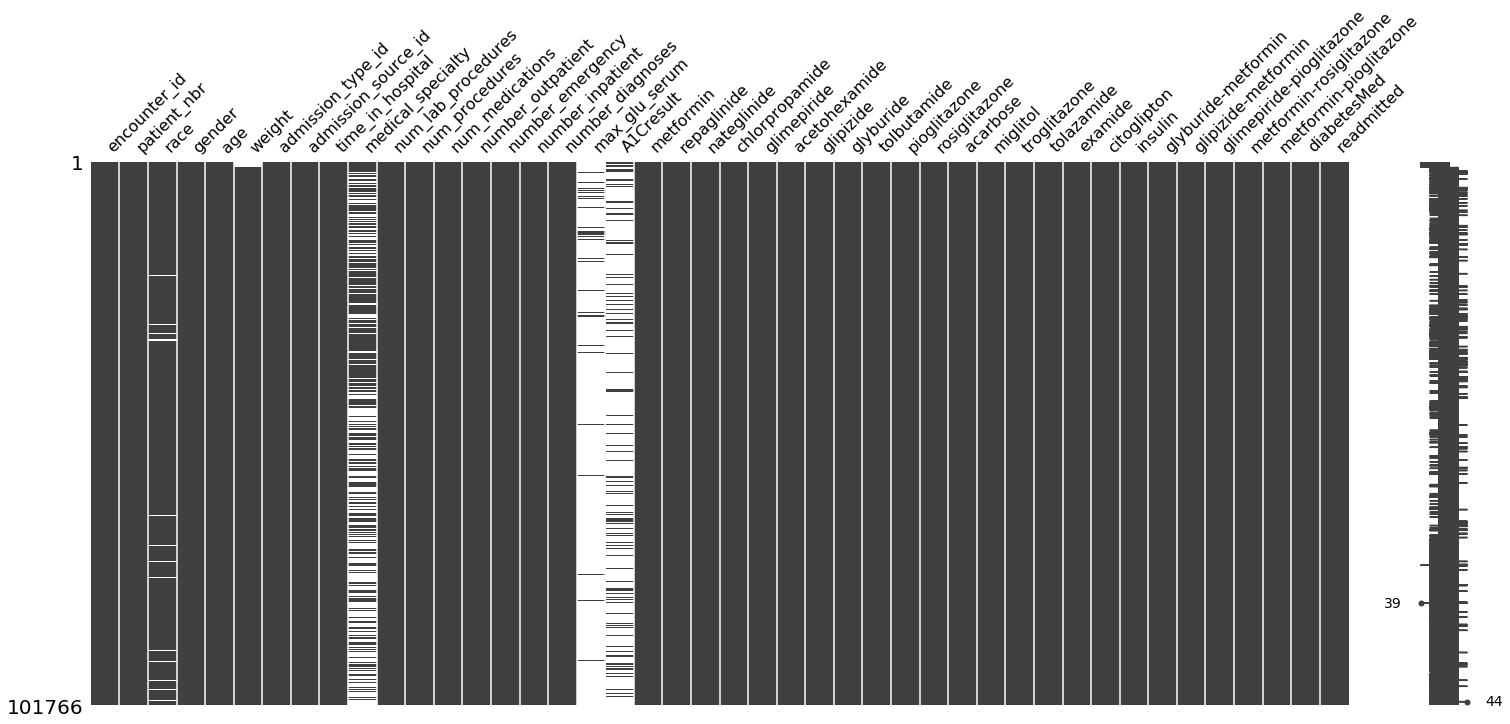

In [111]:
import missingno as msno

msno.matrix(data)

The data-dense columns are fully black, while the sparse columns (with missing values) have a mixture of white and black. 

### Patient Demographics: Age and Gender

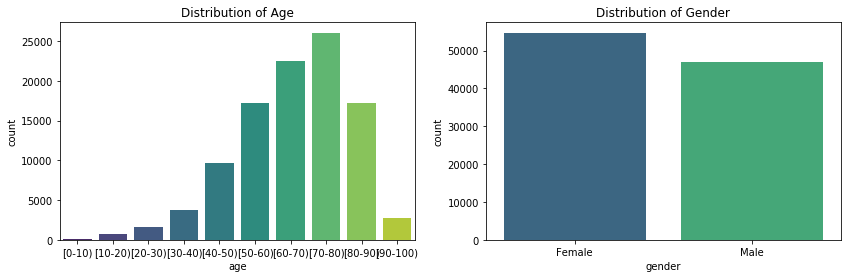

In [41]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.countplot(x='age', data=data, palette='viridis')
plt.title("Distribution of Age")

plt.subplot(1,2,2)
sns.countplot(data['gender'], palette='viridis')
plt.title("Distribution of Gender")
plt.show()

In [42]:
data['gender'].value_counts(normalize=True)

Female    0.537602
Male      0.462398
Name: gender, dtype: float64

### How long were hospital stays for a given admission?

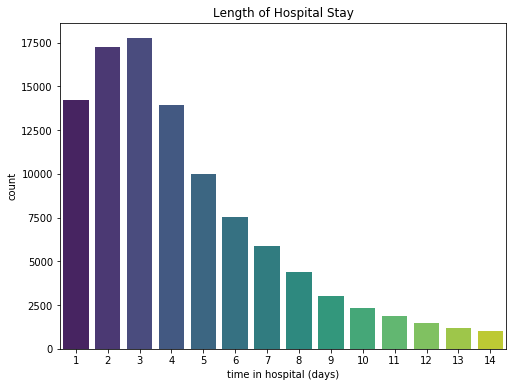

In [43]:
plt.figure(figsize=(8,6))
sns.countplot(data['time_in_hospital'], palette='viridis')
plt.xlabel("time in hospital (days)")
plt.title("Length of Hospital Stay")
plt.show()

In [44]:
print(f"Mean time in hospital: {data['time_in_hospital'].mean():.2f}")

Mean time in hospital: 4.40


### Number of Diagnoses, Procedures, Medications

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Number of Lab Procedures, mean: 43.10')

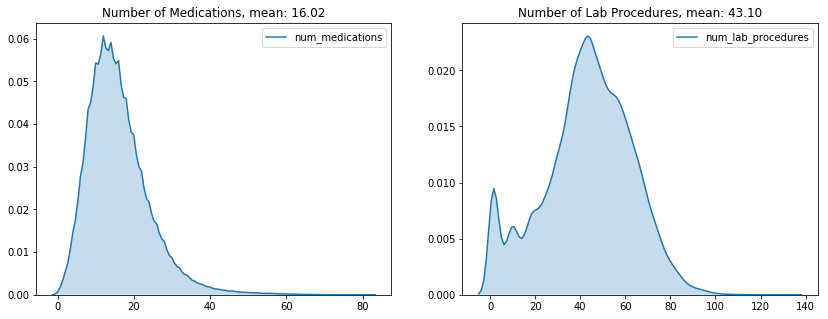

In [45]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.kdeplot(data['num_medications'], shade=True)
plt.title(f"Number of Medications, mean: {data['num_medications'].mean():.2f}")

plt.subplot(1,2,2)
sns.kdeplot(data['num_lab_procedures'], shade=True)
plt.title(f"Number of Lab Procedures, mean: {data['num_lab_procedures'].mean():.2f}")

### What was the most common medical specialty?

Medical specialty of attending physician.

In [46]:
medical_specialties = data['medical_specialty'].value_counts().reset_index()
medical_specialties.columns = ['specialty', 'count']
medical_specialties['prevalence'] = medical_specialties['count']/len(data)

medical_specialties.head(10)

,specialty,count,prevalence
0,InternalMedicine,14635,0.143810
1,Emergency/Trauma,7565,0.074337
2,Family/GeneralPractice,7440,0.073109
3,Cardiology,5352,0.052591
4,Surgery-General,3099,0.030452
5,Nephrology,1613,0.015850
6,Orthopedics,1400,0.013757
7,Orthopedics-Reconstructive,1233,0.012116
8,Radiologist,1140,0.011202
9,Pulmonology,871,0.008559


### Medications

In [47]:
data[medications[3]].value_counts()

No        101680
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64

In [48]:
data['diabetesMed'] = data['diabetesMed'].map({'Yes': 1, 'No':0})
data['diabetesMed'].value_counts()

1    78363
0    23403
Name: diabetesMed, dtype: int64

### A1C 

According to the Mayo Clinic:

> *An A1C level above 8 percent means that your diabetes is not well-controlled and you have a higher risk of developing complications of diabetes.*

In [49]:
data['A1Cresult'].value_counts()

>8      8216
Norm    4990
>7      3812
Name: A1Cresult, dtype: int64

In [7]:
data['A1Cresult_bool'] = np.where(data['A1Cresult']=='Norm', 1, 0)

## Step 5: Feature Selection

Talk about the importance of feature selection / feature engineering.

## Step 6: Building the Binary Classification ML Model

No Free Lunch Theorem!!!

- Support Vector Machine
- Random Forest Classifier
- K-Neighbours
- Logistic Regression
- AdaBoost Classifier

In [51]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetesMed', 'readmitted', 'admission_type',
       'admission_source', 'metformin_bool', 'repaglinide_bool',
       'nateglinide_bool', 'chlorpropamide_bool', 'glimepiride_bool',
       'acetohexamide_bool',

In [52]:
from sklearn.ensemble import AdaBoostClassifier

In [63]:
X = data[['metformin_bool', 'repaglinide_bool',
       'nateglinide_bool', 'chlorpropamide_bool', 'glimepiride_bool',
       'acetohexamide_bool', 'glipizide_bool', 'glyburide_bool',
       'tolbutamide_bool', 'pioglitazone_bool', 'rosiglitazone_bool',
       'acarbose_bool', 'miglitol_bool', 'troglitazone_bool',
       'tolazamide_bool', 'examide_bool', 'citoglipton_bool', 'insulin_bool',
       'glyburide-metformin_bool', 'glipizide-metformin_bool',
       'glimepiride-pioglitazone_bool', 'metformin-rosiglitazone_bool',
       'metformin-pioglitazone_bool', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']]

y = data[['readmitted_bool']]

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

In [72]:
model = AdaBoostClassifier(n_estimators=15)
model.fit(X_train, y_train)
model.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6188616208514506